Section 1: Imports and Setup

In [4]:
!pip install torchinfo seaborn onnx

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pickle
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np

# Define data directory
data_dir = '/content/drive/MyDrive/ANN/PlantVillage'
print(f"[INFO] Dataset directory: {data_dir}")

# Verify directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory {data_dir} not found. Please check the path and ensure the dataset is uploaded.")

[INFO] Dataset directory: /content/drive/MyDrive/ANN/PlantVillage


Section 2: Display Sample Images

🌿 Sample images from different plant disease categories:
[DEBUG] Number of axes created: 5, num_rows: 1, num_cols: 5, num_diseases: 2


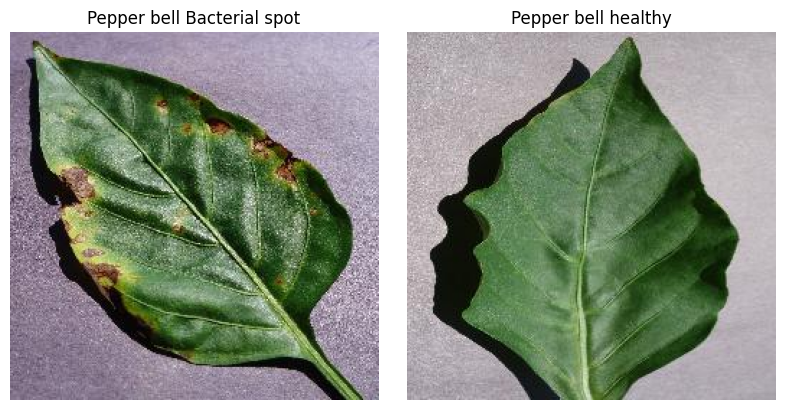

In [5]:
# %%

def display_disease_samples(data_dir, plants=None, num_cols=5):
    disease_folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

    if plants is not None:
        disease_folders = [f for f in disease_folders if any(p in f for p in plants)]

    num_diseases = len(disease_folders)
    if num_diseases == 0:
        print(f"[WARNING] No disease folders found in {data_dir} matching plants {plants}. Please check the dataset.")
        print("Expected folders: Pepper_bell_Bacterial_spot, Pepper_bell_healthy")
        return

    num_rows = (num_diseases + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    print(f"[DEBUG] Number of axes created: {len(axes)}, num_rows: {num_rows}, num_cols: {num_cols}, num_diseases: {num_diseases}")

    for i, disease_folder in enumerate(disease_folders):
        if i >= len(axes):
            print(f"[WARNING] Index {i} out of range for axes list. Stopping display.")
            break
        folder_path = os.path.join(data_dir, disease_folder)

        img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if img_files:
            img_path = os.path.join(folder_path, random.choice(img_files))
            img = Image.open(img_path).convert('RGB')

            disease_name = disease_folder.replace('_', ' ')

            axes[i].imshow(img)
            axes[i].set_title(disease_name, fontsize=12)
            axes[i].axis('off')
        else:
            print(f"[WARNING] No image files found in {disease_folder}")

    # Remove all unused axes
    for j in range(num_diseases, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

print("🌿 Sample images from different plant disease categories:")
display_disease_samples(data_dir, plants=["Pepper_bell"])

Section 3: Dataset Class (with preprocessing)

In [6]:
# %%
import cv2
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class PlantDiseaseDataset(Dataset):
    """Custom Dataset for loading plant disease images with preprocessing"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def preprocess_image(self, img):
        # Convert PIL Image to numpy array
        img_np = np.array(img)

        # Optional: Remove background using simple thresholding (green leaf detection)
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        img_np = cv2.bitwise_and(img_np, img_np, mask=mask)

        # Resize to 224x224 (matching model input)
        img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_AREA)

        # Convert back to PIL Image
        img = Image.fromarray(img_np)
        return img

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image and apply preprocessing
        img = Image.open(img_path).convert("RGB")
        img = self.preprocess_image(img)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

Section 4: Model Definition

In [7]:
# %%

from torchinfo import summary

class PlantDiseaseModel(nn.Module):
    """Convolutional Neural Network for plant disease classification"""
    def __init__(self, num_classes, dropout_rate=0.5):
        super(PlantDiseaseModel, self).__init__()
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Convolutional Block 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Convolutional Block 5
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully Connected Layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x

print(summary(PlantDiseaseModel(2), input_size=(1, 3, 224, 224)))  # 2 classes for pepper

Layer (type:depth-idx)                   Output Shape              Param #
PlantDiseaseModel                        [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          295,168
│

Section 5: Early Stopping Utility

In [8]:
# %%
class EarlyStopping:
    """Early stopping handler to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.save_path)
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

Section 6: Data Loading and Preparation Functions (with preprocessing)

In [9]:
# %%
def load_images(directory_root):
    """Load images and their labels from directory structure"""
    image_list, label_list = [], []
    print("[INFO] Loading images...")

    # Filter only pepper-related folders
    target_folders = ["Pepper_bell_Bacterial_spot", "Pepper_bell_healthy"]
    for disease_folder in os.listdir(directory_root):
        if disease_folder in target_folders:
            disease_folder_path = os.path.join(directory_root, disease_folder)
            if not os.path.isdir(disease_folder_path):
                continue

            for img_name in os.listdir(disease_folder_path):
                if img_name.startswith("."):
                    continue
                img_path = os.path.join(disease_folder_path, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_list.append(img_path)
                    label_list.append(disease_folder)

    print("[INFO] Image loading completed")
    print(f"Total images: {len(image_list)}")
    return image_list, label_list

def prepare_data(directory_root, image_size=(224, 224), batch_size=32, test_size=0.3, valid_ratio=0.5, random_state=42):
    """Prepare data loaders and label encoder with enhanced preprocessing"""
    # Load images and labels
    image_paths, labels = load_images(directory_root)

    # Encode labels as integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Save label encoder for inference
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    # Save class names for reference
    class_names = list(label_encoder.classes_)
    with open('class_names.json', 'w') as f:
        json.dump(class_names, f)

    # Train, validation, and test splits
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels_encoded, test_size=test_size, random_state=random_state, stratify=labels_encoded
    )
    valid_paths, test_paths, valid_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=valid_ratio, random_state=random_state, stratify=temp_labels
    )

    print(f"Training samples: {len(train_paths)}")
    print(f"Validation samples: {len(valid_paths)}")
    print(f"Test samples: {len(test_paths)}")

    # Enhanced Data Transformations
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Random crop for augmentation
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),  # Consistent crop for validation/test
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Save image transformation for inference
    with open('inference_transform.pkl', 'wb') as f:
        pickle.dump(valid_test_transform, f)

    # Create datasets with appropriate transformations
    train_dataset = PlantDiseaseDataset(train_paths, train_labels, transform=train_transform)
    valid_dataset = PlantDiseaseDataset(valid_paths, valid_labels, transform=valid_test_transform)
    test_dataset = PlantDiseaseDataset(test_paths, test_labels, transform=valid_test_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader, len(class_names)

Updated Section 7: Plot Dataset Distribution

[WARNING] 'darkgrid' style not found. Falling back to 'ggplot'.

🌱🌱🌱 Plant Dataset Overview 🌱🌱🌱

🌿 Total Images: 2,475
🌿 Healthy Samples: 1,478 (59.7%)
🌿 Diseased Samples: 997 (40.3%)
🌿 Plant Types: 1
🌿 Disease Categories: 1



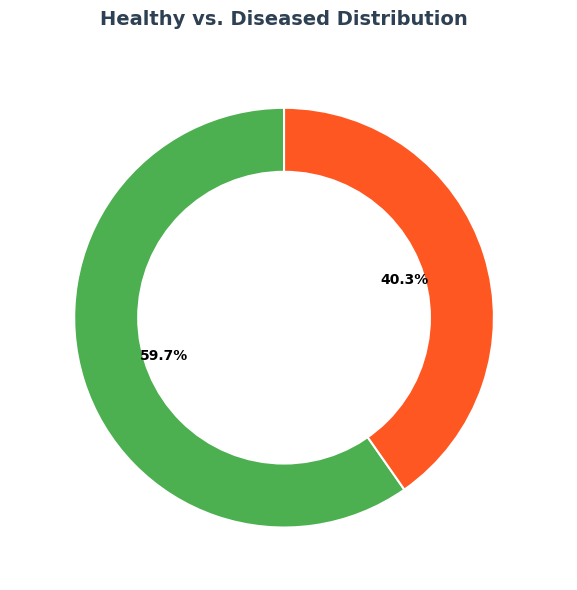

In [10]:
# %%
def plot_dataset_distribution(data_dir):
    folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
    target_folders = ["Pepper_bell_Bacterial_spot", "Pepper_bell_healthy"]
    folders = [f for f in folders if f in target_folders]

    counts = {}
    for folder in folders:
        folder_path = os.path.join(data_dir, folder)
        image_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        counts[folder] = image_count

    plant_data = {}
    for folder, count in counts.items():
        plant = "Pepper bell"
        status = "Healthy" if "healthy" in folder.lower() else "Diseased"

        if plant not in plant_data:
            plant_data[plant] = {"Healthy": 0, "Diseased": 0}
        plant_data[plant][status] += count

    # Set style with fallback
    try:
        plt.style.use('darkgrid')  # Correct Seaborn style name
    except (OSError, FileNotFoundError):
        print("[WARNING] 'darkgrid' style not found. Falling back to 'ggplot'.")
        plt.style.use('ggplot')

    # Prepare data for pie chart
    plants = list(plant_data.keys())
    healthy_counts = [plant_data[p]["Healthy"] for p in plants]
    diseased_counts = [plant_data[p]["Diseased"] for p in plants]
    total_healthy = sum(healthy_counts)
    total_diseased = sum(diseased_counts)
    pie_labels = ['Healthy', 'Diseased']
    pie_sizes = [total_healthy, total_diseased]
    pie_colors = ['#4CAF50', '#FF5722']  # Green for Healthy, Red for Diseased

    # Create pie chart with reduced size
    fig, ax = plt.subplots(figsize=(6, 6))  # Reduced from (10, 10) to (6, 6)
    wedges, texts, autotexts = ax.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=pie_colors,
                                     wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'}, textprops={'fontsize': 10, 'color': 'white'})
    for autotext in autotexts:
        autotext.set_color('black')  # Change autopct text color for readability
        autotext.set_fontweight('bold')

    # Add a circle to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    ax.set_title('Healthy vs. Diseased Distribution\n', fontsize=14, fontweight='bold', color='#2E4053')

    plt.tight_layout()

    # Calculate totals
    total_images = total_healthy + total_diseased

    # Output summary with a unique twist
    print(f"\n{'🌱'*3} Plant Dataset Overview {'🌱'*3}")
    print(f"\n🌿 Total Images: \033[1m{total_images:,}\033[0m")
    print(f"🌿 Healthy Samples: \033[1m{total_healthy:,}\033[0m ({total_healthy/total_images:.1%})")
    print(f"🌿 Diseased Samples: \033[1m{total_diseased:,}\033[0m ({total_diseased/total_images:.1%})")
    print(f"🌿 Plant Types: \033[1m{len(plants)}\033[0m")
    print(f"🌿 Disease Categories: \033[1m{len(folders) - len(healthy_counts)}\033[0m\n")

plot_dataset_distribution(data_dir)

Section 8: Show Augmentations

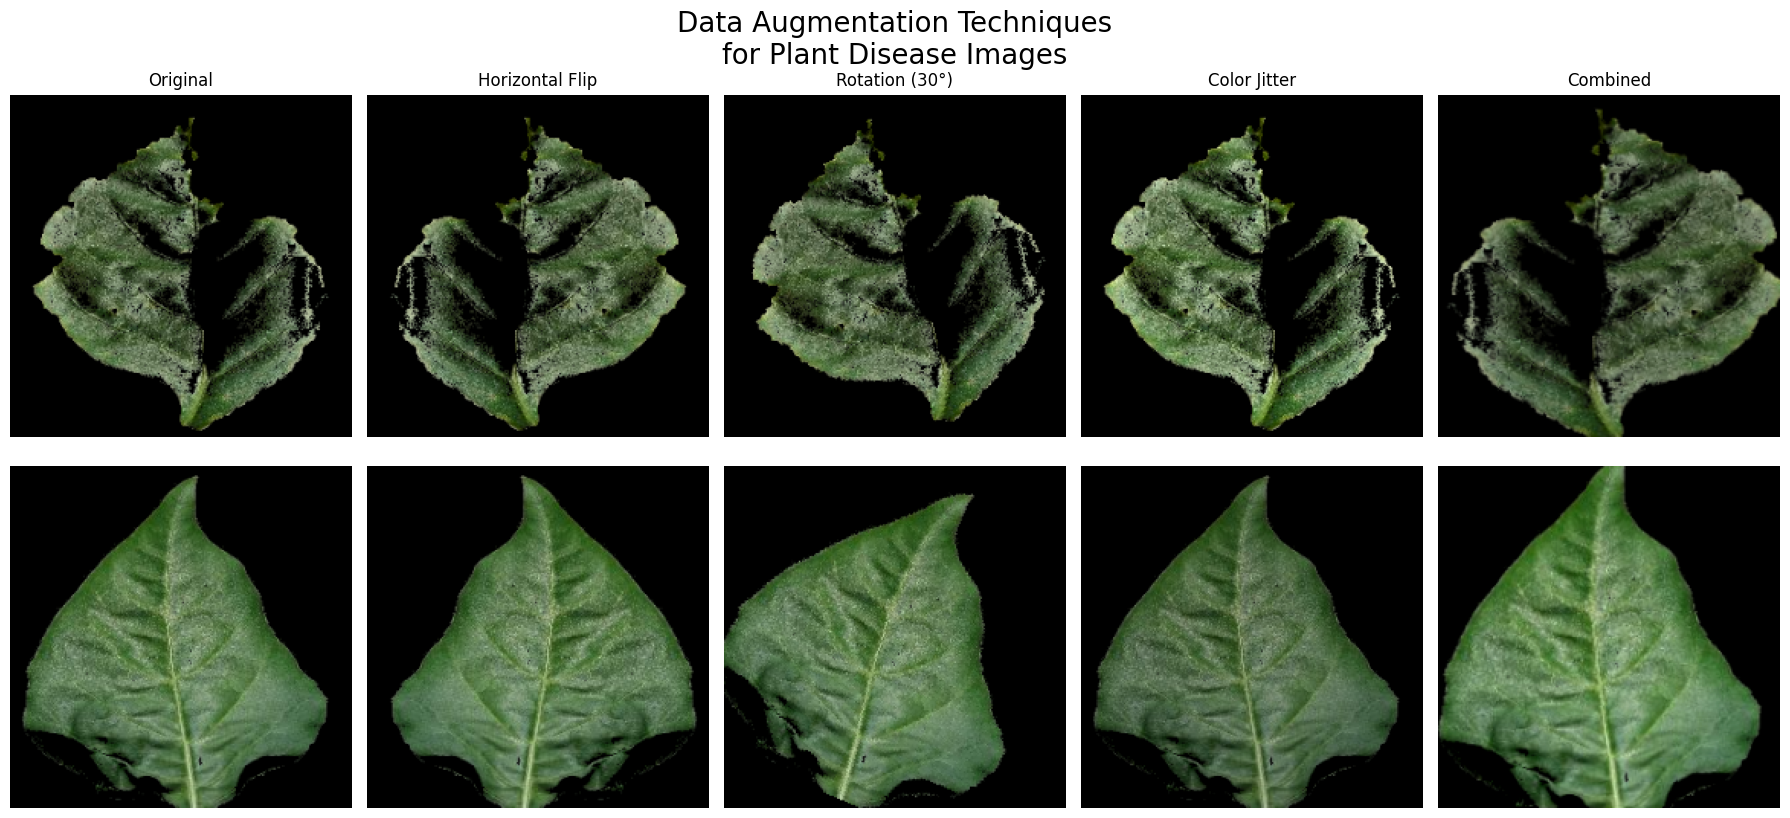

In [11]:
# %%
def show_augmentations(data_dir, num_plants=2):
    disease_folders = ["Pepper_bell_Bacterial_spot", "Pepper_bell_healthy"]
    selected_folders = disease_folders

    augmentations = [
        ("Original", transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])),
        ("Horizontal Flip", transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()])),
        ("Rotation (30°)", transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(30), transforms.ToTensor()])),
        ("Color Jitter", transforms.Compose([transforms.Resize((224, 224)), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), transforms.ToTensor()])),
        ("Combined", transforms.Compose([transforms.Resize((224, 224)), transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20), transforms.ColorJitter(brightness=0.1, contrast=0.1), transforms.ToTensor()]))
    ]

    fig, axes = plt.subplots(len(selected_folders), len(augmentations), figsize=(18, 4 * len(selected_folders)))

    for i, folder in enumerate(selected_folders):
        folder_path = os.path.join(data_dir, folder)

        img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not img_files:
            continue

        img_path = os.path.join(folder_path, random.choice(img_files))
        original_img = Image.open(img_path).convert('RGB')
        original_img = PlantDiseaseDataset.preprocess_image(None, original_img)  # Apply preprocessing

        for j, (aug_name, transform) in enumerate(augmentations):
            img_tensor = transform(original_img)

            img_np = img_tensor.permute(1, 2, 0).numpy()

            ax = axes[i, j] if len(selected_folders) > 1 else axes[j]
            ax.imshow(img_np)

            if i == 0:
                ax.set_title(aug_name, fontsize=12)

            if j == 0:
                disease_name = folder.replace('_', ' ')
                ax.set_ylabel(disease_name, fontsize=10)

            ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Data Augmentation Techniques\nfor Plant Disease Images", fontsize=20, y=1.05)
    plt.show()

show_augmentations(data_dir)

Section 9: Training and Evaluation Functions

In [12]:
# %%
def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on validation or test set"""
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(data_loader), desc="Evaluating", total=len(data_loader))
        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({"Val Loss": loss.item(), "Accuracy": correct / total * 100})

    val_loss /= len(data_loader)
    accuracy = correct / total * 100
    return val_loss, accuracy, np.array(all_preds), np.array(all_labels)

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler=None,
                epochs=10, early_stopping=None, device="cpu"):
    """Train the model with optional early stopping and learning rate scheduler"""
    model.to(device)
    train_losses, valid_losses, valid_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{epochs}",
                           total=len(train_loader))

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Train Loss": loss.item()})

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy, _, _ = evaluate_model(model, valid_loader, criterion, device)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%")

        if scheduler:
            scheduler.step(val_loss)

        if early_stopping and early_stopping(val_loss, model):
            print("[INFO] Early stopping triggered.")
            break

    save_learning_curves(train_losses, valid_losses, valid_accuracies)

    return train_losses, valid_losses, valid_accuracies

def save_learning_curves(train_losses, valid_losses, valid_accuracies):
    """Save learning curves as a plot"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.close()

Section 10: Prediction and Main Training Function (with preprocessing)

In [13]:
# %%
def predict_image(model, image_path, transform, device, label_encoder=None):
    """Make prediction on a single image with preprocessing"""
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = PlantDiseaseDataset.preprocess_image(None, image)  # Use static method
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    predicted_idx = predicted.item()
    confidence = probabilities[0][predicted_idx].item() * 100

    if label_encoder:
        predicted_class = label_encoder.inverse_transform([predicted_idx])[0]
        return predicted_class, confidence, probabilities[0].cpu().numpy()
    else:
        return predicted_idx, confidence, probabilities[0].cpu().numpy()

def train(data_dir, model_save_path="best_model.pth", batch_size=32,
          epochs=30, learning_rate=0.001, image_size=(224, 224)):
    """Main function to train and save the model and necessary files for deployment"""
    train_loader, valid_loader, test_loader, num_classes = prepare_data(
        data_dir, image_size=image_size, batch_size=batch_size
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = PlantDiseaseModel(num_classes=num_classes, dropout_rate=0.5)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True
    )
    early_stopping = EarlyStopping(patience=7, min_delta=0.001, save_path=model_save_path)

    print(f"Model created with {num_classes} output classes")

    train_model(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=epochs,
        early_stopping=early_stopping,
        device=device
    )

    model.load_state_dict(torch.load(model_save_path))

    print("\n[INFO] Evaluating the model on the test set...")
    test_loss, test_accuracy, predictions, true_labels = evaluate_model(
        model, test_loader, criterion, device
    )
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    dummy_input = torch.randn(1, 3, *image_size).to(device)
    torch.onnx.export(model, dummy_input, "plant_disease_model.onnx")

    model_config = {
        "image_size": image_size,
        "num_classes": num_classes,
        "model_path": model_save_path,
        "label_encoder_path": "label_encoder.pkl",
        "transform_path": "inference_transform.pkl",
        "class_names_path": "class_names.json"
    }

    with open("model_config.json", "w") as f:
        json.dump(model_config, f)

    print("[INFO] Training completed and all necessary files saved for deployment.")
    return model, model_config

Section 11: Main Execution

In [14]:
# %%
if __name__ == "__main__":
    model_path = "best_model.pth"
    batch_size = 32
    epochs = 45
    learning_rate = 0.00065

    model, model_config = train(
        data_dir=data_dir,
        model_save_path=model_path,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate
    )

[INFO] Loading images...
[INFO] Image loading completed
Total images: 2475
Training samples: 1732
Validation samples: 371
Test samples: 372
Using device: cuda
Model created with 2 output classes


Evaluating: 100%|██████████| 12/12 [02:37<00:00, 13.10s/it, Val Loss=0.307, Accuracy=93.5]


Epoch 1: Train Loss = 0.3696, Val Loss = 0.1760, Val Accuracy = 93.53%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s, Val Loss=0.202, Accuracy=90.8]


Epoch 2: Train Loss = 0.2461, Val Loss = 0.2183, Val Accuracy = 90.84%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s, Val Loss=0.179, Accuracy=97.8]


Epoch 3: Train Loss = 0.1861, Val Loss = 0.1021, Val Accuracy = 97.84%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s, Val Loss=0.296, Accuracy=96.2]


Epoch 4: Train Loss = 0.1483, Val Loss = 0.0987, Val Accuracy = 96.23%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.38it/s, Val Loss=0.547, Accuracy=92.7]


Epoch 5: Train Loss = 0.1101, Val Loss = 0.2029, Val Accuracy = 92.72%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.68it/s, Val Loss=0.0506, Accuracy=98.9]


Epoch 6: Train Loss = 0.1136, Val Loss = 0.0421, Val Accuracy = 98.92%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s, Val Loss=0.159, Accuracy=97]


Epoch 7: Train Loss = 0.1210, Val Loss = 0.0794, Val Accuracy = 97.04%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.93it/s, Val Loss=0.0393, Accuracy=98.1]


Epoch 8: Train Loss = 0.1336, Val Loss = 0.0663, Val Accuracy = 98.11%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s, Val Loss=0.139, Accuracy=98.1]


Epoch 9: Train Loss = 0.1037, Val Loss = 0.0644, Val Accuracy = 98.11%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s, Val Loss=0.0551, Accuracy=97.3]


Epoch 10: Train Loss = 0.0814, Val Loss = 0.0534, Val Accuracy = 97.30%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s, Val Loss=0.0598, Accuracy=98.9]


Epoch 11: Train Loss = 0.1064, Val Loss = 0.0372, Val Accuracy = 98.92%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s, Val Loss=0.231, Accuracy=97.6]


Epoch 12: Train Loss = 0.0734, Val Loss = 0.0582, Val Accuracy = 97.57%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s, Val Loss=0.0399, Accuracy=99.2]


Epoch 13: Train Loss = 0.0624, Val Loss = 0.0326, Val Accuracy = 99.19%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.30it/s, Val Loss=0.178, Accuracy=98.1]


Epoch 14: Train Loss = 0.0781, Val Loss = 0.0520, Val Accuracy = 98.11%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s, Val Loss=0.0449, Accuracy=99.2]


Epoch 15: Train Loss = 0.0679, Val Loss = 0.0388, Val Accuracy = 99.19%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s, Val Loss=0.0649, Accuracy=99.5]


Epoch 16: Train Loss = 0.0577, Val Loss = 0.0346, Val Accuracy = 99.46%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.14it/s, Val Loss=0.0624, Accuracy=98.9]


Epoch 17: Train Loss = 0.0625, Val Loss = 0.0325, Val Accuracy = 98.92%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.38it/s, Val Loss=0.031, Accuracy=99.2]


Epoch 18: Train Loss = 0.0543, Val Loss = 0.0291, Val Accuracy = 99.19%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, Val Loss=0.0709, Accuracy=98.4]


Epoch 19: Train Loss = 0.0644, Val Loss = 0.0388, Val Accuracy = 98.38%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s, Val Loss=0.0869, Accuracy=98.1]


Epoch 20: Train Loss = 0.0860, Val Loss = 0.0386, Val Accuracy = 98.11%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s, Val Loss=0.0378, Accuracy=98.9]


Epoch 21: Train Loss = 0.0479, Val Loss = 0.0295, Val Accuracy = 98.92%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s, Val Loss=0.0147, Accuracy=98.9]


Epoch 22: Train Loss = 0.0450, Val Loss = 0.0252, Val Accuracy = 98.92%
[INFO] Model checkpoint saved to best_model.pth


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.60it/s, Val Loss=0.0237, Accuracy=98.9]


Epoch 23: Train Loss = 0.0394, Val Loss = 0.0261, Val Accuracy = 98.92%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s, Val Loss=0.0189, Accuracy=99.2]


Epoch 24: Train Loss = 0.0543, Val Loss = 0.0255, Val Accuracy = 99.19%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s, Val Loss=0.0112, Accuracy=98.4]


Epoch 25: Train Loss = 0.0491, Val Loss = 0.0317, Val Accuracy = 98.38%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s, Val Loss=0.0213, Accuracy=98.7]


Epoch 26: Train Loss = 0.0483, Val Loss = 0.0282, Val Accuracy = 98.65%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s, Val Loss=0.0252, Accuracy=98.7]


Epoch 27: Train Loss = 0.0622, Val Loss = 0.0290, Val Accuracy = 98.65%


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  4.32it/s, Val Loss=0.00876, Accuracy=99.2]


Epoch 28: Train Loss = 0.0571, Val Loss = 0.0258, Val Accuracy = 99.19%


Evaluating: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s, Val Loss=0.0119, Accuracy=99.2]


Epoch 29: Train Loss = 0.0340, Val Loss = 0.0249, Val Accuracy = 99.19%
[INFO] Early stopping triggered.
[INFO] Early stopping triggered.

[INFO] Evaluating the model on the test set...


Evaluating: 100%|██████████| 12/12 [02:43<00:00, 13.59s/it, Val Loss=0.0087, Accuracy=99.2]


Test Loss: 0.0227, Test Accuracy: 99.19%
[INFO] Training completed and all necessary files saved for deployment.


Section 12: Visualize Learning Curves

📊 Visualizing Model Training Progress:


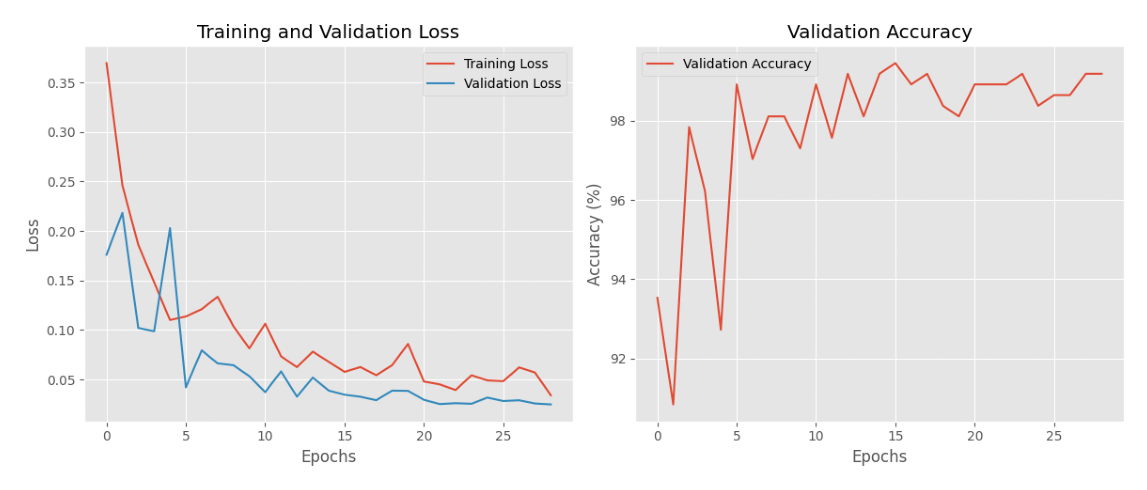

In [15]:
# %%
def visualize_learning_curves():
    try:
        with open('learning_curves.png', 'rb') as f:
            plt.figure(figsize=(12, 5))
            img = plt.imread('learning_curves.png')
            plt.imshow(img)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    except FileNotFoundError:
        print("Learning curves not found. Train the model first.")

print("📊 Visualizing Model Training Progress:")
visualize_learning_curves()

Section 13: Evaluate Model Performance

Using device: cuda
[INFO] Loading images...
[INFO] Image loading completed
Total images: 2475
Training samples: 1732
Validation samples: 371
Test samples: 372

🌿🌿🌿 Bell Pepper Performance Overview 🌿🌿🌿

🌿 Total Samples Evaluated: 372
🌿 Overall Accuracy: 99.2%
🌿 Pepper_bell_healthy Accuracy: 99.5% (Samples: 222)
🌿 Pepper_bell_Bacterial_spot Accuracy: 98.7% (Samples: 150)
🌿 Categories Evaluated: 2



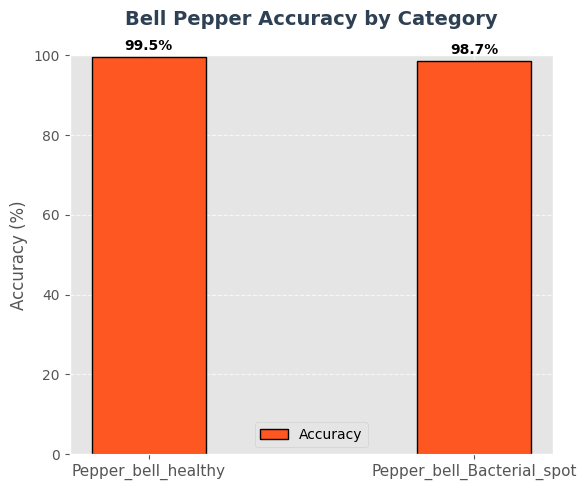

In [17]:
# %%
def evaluate_bell_pepper_performance(model, test_loader, label_encoder, device):
    """Evaluate model performance specifically for bell pepper categories and display as bar chart"""
    model.eval()

    class_correct = {}
    class_total = {}
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i, label in enumerate(labels):
                label_idx = label.item()
                label_name = label_encoder.inverse_transform([label_idx])[0]

                if label_name not in class_correct:
                    class_correct[label_name] = 0
                    class_total[label_name] = 0

                class_total[label_name] += 1
                if preds[i] == label:
                    class_correct[label_name] += 1

    # Calculate accuracy for each category
    bell_pepper_accuracies = {}
    for category in class_correct.keys():
        accuracy = (class_correct[category] / class_total[category]) * 100 if class_total[category] > 0 else 0
        bell_pepper_accuracies[category] = accuracy

    # Prepare data for bar chart
    categories = list(bell_pepper_accuracies.keys())
    accuracy_values = list(bell_pepper_accuracies.values())
    bar_colors = ['#4CAF50' if 'Healthy' in cat else '#FF5722' for cat in categories]  # Green for Healthy, Red for Diseased

    # Create side-by-side bar chart
    fig, ax = plt.subplots(figsize=(6, 5))  # Adjusted size for clarity
    x = np.arange(len(categories))
    width = 0.35

    bars = ax.bar(x, accuracy_values, width, label='Accuracy', color=bar_colors, edgecolor='black', linewidth=1)

    # Add labels and title
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Bell Pepper Accuracy by Category\n', fontsize=14, fontweight='bold', color='#2E4053')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=0, fontsize=11)
    ax.set_ylim(0, 100)  # Set y-axis to percentage range
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.legend()
    plt.tight_layout()

    # Calculate overall accuracy
    total_correct = sum(class_correct.values())
    total_samples = sum(class_total.values())
    overall_accuracy = (total_correct / total_samples) * 100 if total_samples > 0 else 0

    # Output summary with bell pepper emoji
    print(f"\n{'🌿'*3} Bell Pepper Performance Overview {'🌿'*3}")
    print(f"\n🌿 Total Samples Evaluated: \033[1m{total_samples:,}\033[0m")
    print(f"🌿 Overall Accuracy: \033[1m{overall_accuracy:.1f}%\033[0m")
    for category, accuracy in bell_pepper_accuracies.items():
        print(f"🌿 {category} Accuracy: \033[1m{accuracy:.1f}%\033[0m (Samples: {class_total[category]:,})")
    print(f"🌿 Categories Evaluated: \033[1m{len(categories)}\033[0m\n")

    return bell_pepper_accuracies, all_preds, all_labels  # Return predictions and labels for confusion matrix

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and evaluate
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

_, _, test_loader, _ = prepare_data(data_dir, batch_size=32)
bell_pepper_accuracies, all_preds, all_labels = evaluate_bell_pepper_performance(model, test_loader, label_encoder, device)

Section 14: Confusion Matrix


🌿🌿🌿 Bell Pepper Confusion Matrix Insights 🌿🌿🌿
🌿 Overall Accuracy from Confusion Matrix: 99.2%
🌿 Pepper_bell_Bacterial_spot - Precision: 0.99, Recall: 0.99
🌿 Pepper_bell_healthy - Precision: 0.99, Recall: 1.00


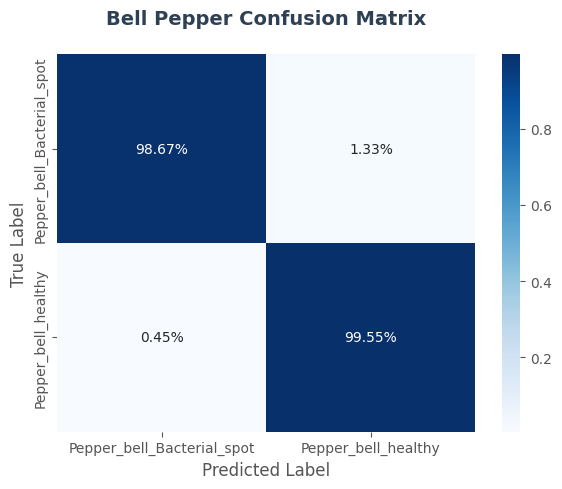

In [19]:
# %%
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(all_preds, all_labels, label_encoder):
    # Use numeric labels directly (no transformation needed)
    true_labels = all_labels
    pred_labels = all_preds

    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentage

    # Get category names from label encoder
    categories = label_encoder.classes_

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Bell Pepper Confusion Matrix\n', fontsize=14, fontweight='bold', color='#2E4053')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    # Output additional metrics
    accuracy = np.trace(cm) / np.sum(cm) * 100
    print(f"\n{'🌿'*3} Bell Pepper Confusion Matrix Insights {'🌿'*3}")
    print(f"🌿 Overall Accuracy from Confusion Matrix: \033[1m{accuracy:.1f}%\033[0m")
    for i in range(len(categories)):
        precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:, i]) > 0 else 0
        recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
        print(f"🌿 {categories[i]} - Precision: \033[1m{precision:.2f}\033[0m, Recall: \033[1m{recall:.2f}\033[0m")

# Plot confusion matrix using predictions and labels from evaluation
plot_confusion_matrix(all_preds, all_labels, label_encoder)